In [6]:
import pandas as pd
import re
import numpy as np
from datetime import timedelta
import seaborn as sns
import json
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Generate
# intogen_output_path = "/workspace/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/intogen_output"
# o3d_output_path = "/workspace/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/human_mane_raw/run_2024-06-26_14-53-50/pipeline_info"
generate_intogen_tsv = "cat trace.txt | cut -f 4,9,10,16 | grep -e ^CBaSE -e ^HotMAPS -e ^MutPanning -e ^OncodriveCLUSTL -e ^OncodriveFML -e ^SMRegions -e ^dNdScv | sort -k 2 > /workspace/projects/clustering_3d/o3d_analysys/o3d_paper/fig4_resources_analysis/traces/intogen_methods_trace.tsv"
generate_o3d_tsv = "cat trace-20231031-64800245.txt | cut -f 4,9,10,16 | grep -e ^Oncodrive3D -e ^SEISMIC -e ^CBaSE -e ^HotMAPS -e ^MutPanning -e ^OncodriveCLUSTL -e ^OncodriveFML -e ^SMRegions -e ^dNdScv | sort -k 2 > /workspace/projects/clustering_3d/o3d_analysys/o3d_paper/fig4_resources_analysis/traces/oncodrive3d_trace.tsv"

In [8]:
intogen_tsv = "traces/intogen_methods_trace.tsv"
o3d_tsv = "traces/oncodrive3d_trace.tsv"

In [9]:
def get_hours(duration):
    
    # Parse the duration components
    duration_parts = duration.split()
    days = 0
    hours = 0
    minutes = 0
    seconds = 0

    for part in duration_parts:
        if part.endswith("d"):
            days = float(part[:-1])
        elif part.endswith("h"):
            hours = float(part[:-1])
        elif part.endswith("ms"):
            pass
        elif part.endswith("m"):
            minutes = float(part[:-1])
        elif part.endswith("s"):
            seconds = float(part[:-1])

    # Calculate the total hours
    total_hours = (days * 24) + hours + (minutes / 60) + (seconds / 3600)
    
    return total_hours

### Intogen methods

In [10]:
names_dict = {"Oncodrive3D" : "Oncodrive3D", 
              "HotMAPS" : "3D clustering", 
              "OncodriveCLUSTL" : "Linear clustering", 
              "SMRegions" : "Domain enrichment", 
              "OncodriveFML" : "Functional impact",
              "dNdScv" : "Mut excess A", 
              "CBaSE" : "Mut excess B", 
              "MutPanning" : "Mut excess C*"}

colors_dict = {names_dict["Oncodrive3D"] : "#ffad48", 
               names_dict["HotMAPS"] : "#024b79", 
               names_dict["OncodriveCLUSTL"] : "#43b7c2", 
               names_dict["SMRegions"] : "#c2f1ce", 
               names_dict["OncodriveFML"] : "#bbd9f6",
               names_dict["dNdScv"] : "#edd7c5", 
               names_dict["CBaSE"] : "#ffb8b3", 
               names_dict["MutPanning"] : "#cee4d8"}

cpu_allocated = {"OncodriveFML" : 14,
                 "OncodriveCLUSTL" : 14,
                 "MutPanning" : 8,
                 "HotMAPS" : 14,
                 "Oncodrive3D" : 14,
                 "SMRegions" : 14,
                 "dNdScv" : 1,
                 "CBaSE" : 1,
                 "SEISMIC" : 1}

In [11]:
# Get HotMAPS & others
methods = pd.read_csv(intogen_tsv, sep="\t", header=None)
methods["Method"] = methods.apply(lambda x: x[0].split(" ")[0], axis=1)
methods["Cohort"] = methods.apply(lambda x: x[0].split(" ")[2], axis=1)
methods = methods.drop(columns=[0])
methods = methods.rename(columns = {1 : "CPU%", 2 : "Memory", 3 : "Time"})
methods["CPU%"] = methods.apply(lambda x: re.sub(r'[^0-9.]', "", x["CPU%"]), axis=1)
methods["Cohort"] = methods.apply(lambda x: re.sub(r'\)', "", x["Cohort"]), axis=1)
methods["CPU%"] = pd.to_numeric(methods["CPU%"])
methods.insert(0, "Method", methods.pop("Method"))
methods["CPU_allocated"] = methods.apply(lambda x: cpu_allocated[x["Method"]], axis=1)
methods

,Method,CPU%,Memory,Time,Cohort,CPU_allocated
0,CBaSE,100.1,1.8 GB,54m 24s,CBIOP_WGS_PRAD_EURUROL_2017,1
1,CBaSE,98.8,1.6 GB,45m 25s,CBIOP_WGS_STAD_ONCOSG_2018,1
2,CBaSE,100.0,2 GB,53m 49s,CBIOP_WXS_ACY_2019,1
3,CBaSE,99.1,2.9 GB,27m 36s,CBIOP_WXS_ACYC_MDA_2015,1
4,CBaSE,99.7,3.2 GB,57m 21s,CBIOP_WXS_ACYC_SANGER_2013,1
...,...,...,...,...,...,...
1880,SMRegions,73.4,4.3 GB,46.5s,TCGA_WXS_THYM,14
1881,SMRegions,637.4,64.2 GB,50.2s,TCGA_WXS_UCEC,14
1882,SMRegions,135.9,4.3 GB,23.4s,TCGA_WXS_UCS,14
1883,SMRegions,115.6,4.3 GB,23.7s,TCGA_WXS_UM,14


In [12]:
cpu_allocated = {names_dict["Oncodrive3D"] : 14, 
               names_dict["HotMAPS"] : 14, 
               names_dict["OncodriveCLUSTL"] : 14, 
               names_dict["SMRegions"] : 14, 
               names_dict["OncodriveFML"] : 14,
               names_dict["dNdScv"] : 1, 
               names_dict["CBaSE"] : 1, 
               names_dict["MutPanning"] : 8}

# New names ForPresentation
methods["Method"] = methods["Method"].map(names_dict)
methods

,Method,CPU%,Memory,Time,Cohort,CPU_allocated
0,Mut excess B,100.1,1.8 GB,54m 24s,CBIOP_WGS_PRAD_EURUROL_2017,1
1,Mut excess B,98.8,1.6 GB,45m 25s,CBIOP_WGS_STAD_ONCOSG_2018,1
2,Mut excess B,100.0,2 GB,53m 49s,CBIOP_WXS_ACY_2019,1
3,Mut excess B,99.1,2.9 GB,27m 36s,CBIOP_WXS_ACYC_MDA_2015,1
4,Mut excess B,99.7,3.2 GB,57m 21s,CBIOP_WXS_ACYC_SANGER_2013,1
...,...,...,...,...,...,...
1880,Domain enrichment,73.4,4.3 GB,46.5s,TCGA_WXS_THYM,14
1881,Domain enrichment,637.4,64.2 GB,50.2s,TCGA_WXS_UCEC,14
1882,Domain enrichment,135.9,4.3 GB,23.4s,TCGA_WXS_UCS,14
1883,Domain enrichment,115.6,4.3 GB,23.7s,TCGA_WXS_UM,14


In [13]:
# hotmaps = methods[methods["Method"] == "HotMAPS"].reset_index(drop=True)
# hotmaps
# hotmaps = hotmaps[~hotmaps["Cohort"].str.startswith("ICGC")]
# hotmaps

### Oncodrive3D

In [14]:
o3d = pd.read_csv(o3d_tsv, sep="\t", header=None)
o3d

,0,1,2,3
0,O3D_run (O3D CBIOP_WGS_PRAD_EURUROL_2017),282.9%,25.3 GB,48.8s
1,O3D_run (O3D CBIOP_WGS_STAD_ONCOSG_2018),585.7%,41.4 GB,20m 50s
2,O3D_run (O3D CBIOP_WXS_ACY_2019),438.3%,28.1 GB,1m 41s
3,O3D_run (O3D CBIOP_WXS_ACYC_MDA_2015),617.4%,26.7 GB,54.1s
4,O3D_run (O3D CBIOP_WXS_ACYC_SANGER_2013),229.3%,23.8 GB,15.1s
...,...,...,...,...
266,O3D_run (O3D TCGA_WXS_THYM),548.9%,26.3 GB,1m 10s
267,O3D_run (O3D TCGA_WXS_UCEC),1216.6%,52.5 GB,45m 23s
268,O3D_run (O3D TCGA_WXS_UCS),612.1%,26.5 GB,1m 36s
269,O3D_run (O3D TCGA_WXS_UM),385.0%,26 GB,50s


In [15]:
# Get O3D 
o3d = pd.read_csv(o3d_tsv, sep="\t", header=None)
o3d["Method"] = o3d.apply(lambda x: x[0].split(" ")[0], axis=1)
o3d["Cohort"] = o3d.apply(lambda x: x[0].split(" ")[2], axis=1)
o3d = o3d.drop(columns=[0])
o3d = o3d.rename(columns = {1 : "CPU%", 2 : "Memory", 3 : "Time"})
o3d["CPU%"] = o3d.apply(lambda x: re.sub(r'[^0-9.]', "", x["CPU%"]), axis=1)
o3d["Cohort"] = o3d.apply(lambda x: re.sub(r'\)', "", x["Cohort"]), axis=1)
o3d["CPU%"] = pd.to_numeric(o3d["CPU%"])
o3d[o3d["Method"] == "O3D_run"]
o3d["Method"] = "Oncodrive3D"
o3d["CPU_allocated"] = o3d.apply(lambda x: cpu_allocated[x["Method"]], axis=1)
o3d

,CPU%,Memory,Time,Method,Cohort,CPU_allocated
0,282.9,25.3 GB,48.8s,Oncodrive3D,CBIOP_WGS_PRAD_EURUROL_2017,14
1,585.7,41.4 GB,20m 50s,Oncodrive3D,CBIOP_WGS_STAD_ONCOSG_2018,14
2,438.3,28.1 GB,1m 41s,Oncodrive3D,CBIOP_WXS_ACY_2019,14
3,617.4,26.7 GB,54.1s,Oncodrive3D,CBIOP_WXS_ACYC_MDA_2015,14
4,229.3,23.8 GB,15.1s,Oncodrive3D,CBIOP_WXS_ACYC_SANGER_2013,14
...,...,...,...,...,...,...
266,548.9,26.3 GB,1m 10s,Oncodrive3D,TCGA_WXS_THYM,14
267,1216.6,52.5 GB,45m 23s,Oncodrive3D,TCGA_WXS_UCEC,14
268,612.1,26.5 GB,1m 36s,Oncodrive3D,TCGA_WXS_UCS,14
269,385.0,26 GB,50s,Oncodrive3D,TCGA_WXS_UM,14


### Get IntOGen methods (old)

In [16]:
# path_dir = "/workspace/projects/clustering_3d/evaluation/optimization_analysis"
# methods = pd.read_csv(f"{path_dir}/intogen_methods_all_cohorts.tsv", sep="\t", header=None)
# methods["Method"] = methods.apply(lambda x: x[0].split(" ")[0], axis=1)
# methods["Cohort"] = methods.apply(lambda x: x[0].split(" ")[2], axis=1)
# methods = methods.drop(columns=[0])
# methods = methods.rename(columns = {1 : "CPU%", 2 : "Memory", 3 : "Time"})
# methods["CPU%"] = methods.apply(lambda x: re.sub(r'[^0-9.]', "", x["CPU%"]), axis=1)
# methods["Cohort"] = methods.apply(lambda x: re.sub(r'\)', "", x["Cohort"]), axis=1)
# methods["CPU%"] = pd.to_numeric(methods["CPU%"])
# methods.insert(0, "Method", methods.pop("Method"))
# methods["CPU_allocated"] = methods.apply(lambda x: cpu_allocated[x["Method"]], axis=1)
# methods

### Get Oncodrive3D (old)

In [17]:
# path_dir = "/workspace/projects/clustering_3d/evaluation/optimization_analysis"
# o3d = pd.read_csv(trace_oncodrive3d_path, sep="\t", header=None)
# o3d["Method"] = o3d.apply(lambda x: x[0].split(" ")[0], axis=1)
# o3d["Cohort"] = o3d.apply(lambda x: x[0].split(" (Clustering on ")[1].replace(")", ""), axis=1)
# o3d = o3d.drop(columns=[0])
# o3d = o3d.rename(columns = {1 : "CPU%", 2 : "Memory", 3 : "Time"})
# o3d["CPU%"] = o3d.apply(lambda x: re.sub(r'[^0-9.]', "", x["CPU%"]), axis=1)
# o3d["Cohort"] = o3d.apply(lambda x: re.sub(r'\)', "", x["Cohort"]), axis=1)
# o3d["CPU%"] = pd.to_numeric(o3d["CPU%"])
# o3d.insert(0, "Method", o3d.pop("Method"))
# o3d["Method"] = "Oncodrive3D"
# o3d["CPU_allocated"] = o3d.apply(lambda x: cpu_allocated[x["Method"]], axis=1)
# o3d

### Concat

In [18]:
cohorts = [cohort for cohort in o3d.Cohort.unique() if cohort in methods.Cohort.unique()]
methods = pd.concat((o3d[[c in cohorts for c in o3d.Cohort]], 
                     methods[[c in cohorts for c in methods.Cohort]])).sort_values(["Cohort"]).reset_index(drop=True)
methods

,CPU%,Memory,Time,Method,Cohort,CPU_allocated
0,282.9,25.3 GB,48.8s,Oncodrive3D,CBIOP_WGS_PRAD_EURUROL_2017,14
1,303.0,54.9 GB,2m 11s,Linear clustering,CBIOP_WGS_PRAD_EURUROL_2017,14
2,125.5,34.7 GB,11m 15s,Mut excess C*,CBIOP_WGS_PRAD_EURUROL_2017,8
3,463.1,47.3 GB,1h 51m 12s,3D clustering,CBIOP_WGS_PRAD_EURUROL_2017,14
4,82.1,4.4 GB,34.9s,Domain enrichment,CBIOP_WGS_PRAD_EURUROL_2017,14
...,...,...,...,...,...,...
2151,99.9,2.8 GB,1m 2s,Mut excess A,TCGA_WXS_WDTC,1
2152,99.1,1.6 GB,31m 45s,Mut excess B,TCGA_WXS_WDTC,1
2153,786.8,29.9 GB,3m 44s,Oncodrive3D,TCGA_WXS_WDTC,14
2154,579.6,83.7 GB,4m 1s,Functional impact,TCGA_WXS_WDTC,14


### Complete parsing

In [19]:
methods = methods[~methods.isna().any(axis=1)]
methods["Time"] = methods.apply(lambda x: get_hours(x["Time"]), axis=1)
methods["Memory"] = pd.to_numeric(methods.apply(lambda x: re.sub(r'[^0-9.]', "", x["Memory"]), axis=1))
methods = methods.rename(columns = {"Memory" : "Memory_GB", "Time" : "Time_H"})
methods

/tmp/jobs/spellegrini/10373218/ipykernel_400739/3593371436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  methods["Time"] = methods.apply(lambda x: get_hours(x["Time"]), axis=1)
/tmp/jobs/spellegrini/10373218/ipykernel_400739/3593371436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  methods["Memory"] = pd.to_numeric(methods.apply(lambda x: re.sub(r'[^0-9.]', "", x["Memory"]), axis=1))


,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated
0,282.9,25.3,0.013556,Oncodrive3D,CBIOP_WGS_PRAD_EURUROL_2017,14
1,303.0,54.9,0.036389,Linear clustering,CBIOP_WGS_PRAD_EURUROL_2017,14
2,125.5,34.7,0.187500,Mut excess C*,CBIOP_WGS_PRAD_EURUROL_2017,8
3,463.1,47.3,1.853333,3D clustering,CBIOP_WGS_PRAD_EURUROL_2017,14
4,82.1,4.4,0.009694,Domain enrichment,CBIOP_WGS_PRAD_EURUROL_2017,14
...,...,...,...,...,...,...
2151,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_WDTC,1
2152,99.1,1.6,0.529167,Mut excess B,TCGA_WXS_WDTC,1
2153,786.8,29.9,0.062222,Oncodrive3D,TCGA_WXS_WDTC,14
2154,579.6,83.7,0.066944,Functional impact,TCGA_WXS_WDTC,14


In [103]:
test = methods[methods["Cohort"].str.startswith("TCGA")]
test = test[test["Method"] == "Oncodrive3D"].sort_values("Time_H")
test

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated
1956,434.5,26.1,0.013139,Oncodrive3D,TCGA_WXS_CHRCC,14
2146,385.0,26.0,0.013889,Oncodrive3D,TCGA_WXS_UM,14
2044,678.5,26.8,0.014750,Oncodrive3D,TCGA_WXS_MGCT,14
1952,481.7,26.4,0.015167,Oncodrive3D,TCGA_WXS_CHOL,14
2117,548.9,26.3,0.019444,Oncodrive3D,TCGA_WXS_THYM,14
2069,287.4,25.0,0.025278,Oncodrive3D,TCGA_WXS_PGNG,14
2135,612.1,26.5,0.026667,Oncodrive3D,TCGA_WXS_UCS,14
1907,729.2,26.3,0.031944,Oncodrive3D,TCGA_WXS_ACC,14
2080,294.1,26.9,0.037778,Oncodrive3D,TCGA_WXS_PLMESO,14
1972,766.5,27.5,0.038611,Oncodrive3D,TCGA_WXS_DLBCLNOS,14


In [20]:
methods[methods["Cohort"] == "TCGA_WXS_MEL"]

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated
2036,1247.9,57.6,1.785000,Oncodrive3D,TCGA_WXS_MEL,14
2037,100.1,2.7,0.126111,Mut excess A,TCGA_WXS_MEL,1
2038,771.1,85.1,37.961667,3D clustering,TCGA_WXS_MEL,14
2039,122.7,34.8,0.290000,Mut excess C*,TCGA_WXS_MEL,8
2040,960.2,86.1,0.136667,Functional impact,TCGA_WXS_MEL,14
2041,480.0,77.6,7.391111,Linear clustering,TCGA_WXS_MEL,14
2042,99.0,2.0,4.030278,Mut excess B,TCGA_WXS_MEL,1
2043,619.2,66.1,0.025833,Domain enrichment,TCGA_WXS_MEL,14


## Plot

In [21]:
methods = methods[~methods["Cohort"].str.startswith("ICGC")].reset_index(drop=True)
methods

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated
0,282.9,25.3,0.013556,Oncodrive3D,CBIOP_WGS_PRAD_EURUROL_2017,14
1,303.0,54.9,0.036389,Linear clustering,CBIOP_WGS_PRAD_EURUROL_2017,14
2,125.5,34.7,0.187500,Mut excess C*,CBIOP_WGS_PRAD_EURUROL_2017,8
3,463.1,47.3,1.853333,3D clustering,CBIOP_WGS_PRAD_EURUROL_2017,14
4,82.1,4.4,0.009694,Domain enrichment,CBIOP_WGS_PRAD_EURUROL_2017,14
...,...,...,...,...,...,...
1715,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_WDTC,1
1716,99.1,1.6,0.529167,Mut excess B,TCGA_WXS_WDTC,1
1717,786.8,29.9,0.062222,Oncodrive3D,TCGA_WXS_WDTC,14
1718,579.6,83.7,0.066944,Functional impact,TCGA_WXS_WDTC,14


In [22]:
methods_tcga = methods[methods["Cohort"].str.startswith("TCGA")].reset_index(drop=True)
methods_tcga

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated
0,298.4,61.4,0.087778,Linear clustering,TCGA_WXS_ACC,14
1,128.2,34.7,0.179722,Mut excess C*,TCGA_WXS_ACC,8
2,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_ACC,1
3,565.8,83.3,0.050000,Functional impact,TCGA_WXS_ACC,14
4,112.8,4.3,0.009222,Domain enrichment,TCGA_WXS_ACC,14
...,...,...,...,...,...,...
251,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_WDTC,1
252,99.1,1.6,0.529167,Mut excess B,TCGA_WXS_WDTC,1
253,786.8,29.9,0.062222,Oncodrive3D,TCGA_WXS_WDTC,14
254,579.6,83.7,0.066944,Functional impact,TCGA_WXS_WDTC,14


In [23]:
methods_tcga = methods[methods["Cohort"].str.startswith("TCGA")]
average = methods_tcga.groupby("Cohort").mean()
average.columns = [f"{col}_avg" for col in average.columns]
average = average.reset_index()
methods_tcga = methods_tcga.merge(average, how="left", on="Cohort")
methods_tcga

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated,CPU%_avg,Memory_GB_avg,Time_H_avg,CPU_allocated_avg
0,298.4,61.4,0.087778,Linear clustering,TCGA_WXS_ACC,14,321.325,33.1750,0.425979,10.0
1,128.2,34.7,0.179722,Mut excess C*,TCGA_WXS_ACC,8,321.325,33.1750,0.425979,10.0
2,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_ACC,1,321.325,33.1750,0.425979,10.0
3,565.8,83.3,0.050000,Functional impact,TCGA_WXS_ACC,14,321.325,33.1750,0.425979,10.0
4,112.8,4.3,0.009222,Domain enrichment,TCGA_WXS_ACC,14,321.325,33.1750,0.425979,10.0
...,...,...,...,...,...,...,...,...,...,...
251,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_WDTC,1,359.075,37.9375,0.876618,10.0
252,99.1,1.6,0.529167,Mut excess B,TCGA_WXS_WDTC,1,359.075,37.9375,0.876618,10.0
253,786.8,29.9,0.062222,Oncodrive3D,TCGA_WXS_WDTC,14,359.075,37.9375,0.876618,10.0
254,579.6,83.7,0.066944,Functional impact,TCGA_WXS_WDTC,14,359.075,37.9375,0.876618,10.0


In [24]:
average = methods.groupby("Cohort").mean()
average.columns = [f"{col}_avg" for col in average.columns]
average = average.reset_index()
methods = methods.merge(average, how="left", on="Cohort")
methods

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated,CPU%_avg,Memory_GB_avg,Time_H_avg,CPU_allocated_avg
0,282.9,25.3,0.013556,Oncodrive3D,CBIOP_WGS_PRAD_EURUROL_2017,14,235.6375,31.6875,0.379979,10.0
1,303.0,54.9,0.036389,Linear clustering,CBIOP_WGS_PRAD_EURUROL_2017,14,235.6375,31.6875,0.379979,10.0
2,125.5,34.7,0.187500,Mut excess C*,CBIOP_WGS_PRAD_EURUROL_2017,8,235.6375,31.6875,0.379979,10.0
3,463.1,47.3,1.853333,3D clustering,CBIOP_WGS_PRAD_EURUROL_2017,14,235.6375,31.6875,0.379979,10.0
4,82.1,4.4,0.009694,Domain enrichment,CBIOP_WGS_PRAD_EURUROL_2017,14,235.6375,31.6875,0.379979,10.0
...,...,...,...,...,...,...,...,...,...,...
1715,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_WDTC,1,359.0750,37.9375,0.876618,10.0
1716,99.1,1.6,0.529167,Mut excess B,TCGA_WXS_WDTC,1,359.0750,37.9375,0.876618,10.0
1717,786.8,29.9,0.062222,Oncodrive3D,TCGA_WXS_WDTC,14,359.0750,37.9375,0.876618,10.0
1718,579.6,83.7,0.066944,Functional impact,TCGA_WXS_WDTC,14,359.0750,37.9375,0.876618,10.0


In [25]:
def plot_performance(df, colors_dic, title, ax, text_ylabel, cpu_allocated,
                     smooth = False, ema_w = 0.9,
                     xlabel = True, ylabel = True,
                     legend = True, target="Time_H", metric="H",
                     style="-", plot_xticks=True, extract_cancer=True):
    
    df = df.copy()
    if extract_cancer:
        df["Cohort"] = df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
    df = df.set_index("Cohort")
    
    sorted_methods=df.groupby("Method")[target].mean().sort_values(ascending=False).index
    
    for method in sorted_methods:
        
        if method in ["3D clustering", "Oncodrive3D", "Linear clustering"]:
            alpha=1
        else:
            alpha=0.7

        x = df.loc[df["Method"] == method]
        
        if smooth:
            xs = ema_smooth(x[target], ema_w)
        else: 
            xs = x[target]
        ax.plot(xs, style, color = colors_dic[method], 
                label = f"{method} (cores = {cpu_allocated[method]})", zorder = get_zorder(method), alpha=alpha)
    
    ax.legend(fontsize = 14, ncol = 1, frameon=False)
    if not legend:
        ax.get_legend().remove()
    
    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 
    else:
        plt.xticks([])
    # ax.tick_params(axis='y', labelsize=12)
    
    if ylabel:
        ax.set_ylabel(text_ylabel, fontsize = 16)
    else:
        ax.set_ylabel("\n\n", fontsize = 16)
    
    plt.yticks(fontsize=15)    
    plt.xticks(fontsize=12)    
    ax.set_xlabel("\nCohort\n", fontsize = 16)
    ax.set_title(title, fontsize = 18)
    ax.grid(False)
    ax.spines["left"].set_color("darkgray")
    ax.spines["right"].set_color("white")
    ax.spines["bottom"].set_color("darkgray")
    ax.spines["top"].set_color("white")   
    
    
def get_zorder(col):
    """
    Prioritize order of the clustering methods
    """
    
    if col == "Oncodrive3D":
        zorder = 3
    elif col == "3D clustering":
        zorder = 2
    elif col == "Linear clustering":
        zorder = 1
    else:
        zorder = 0
        
    return zorder


def ema_smooth(scalars, weight):
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    
    NB: copied from stack-overflow
    """
    
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed

In [26]:
def tick_generator(df):
    """
    Returns a list with the y ticks labels and its descreptive statistic
    """
    ticks_list = []
    for method in df["Method"]:
        ticks_list.append(method)
    return ticks_list


def plot_sum(df, color_dic, title, ax, distance, xlabel_text, 
             xlabel = True, ylabel = False, legend = True, target = "Time_H", metric="H", rotation=0, rotate_xticks=False):
    """
    Plot count bar plot summary
    """
    
    df = df.copy()
    data = df.groupby("Method").sum().sort_values(target, ascending=False).reset_index()
    bar_plot = sns.barplot(data = data, x = target, y = "Method", palette = color_dic, ax = ax)
    
    # Config labels
    if xlabel:
        bar_plot.set_xlabel(xlabel_text,size = 16)
    else:
        bar_plot.set_xlabel("\n\n", size = 16)
        
    bar_plot.set_ylabel("")
    bar_plot.tick_params(axis="y", which = "major", labelsize = 15, direction = "in")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=rotation)
    if rotate_xticks:
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 
    plt.xticks(fontsize=15)
    
    # Add text on the right of each bar
    avg = methods.groupby("Method").mean().reset_index()
    for i, (p, pr) in enumerate(zip(data["Method"], data[target])):
        
        # Add avg info
        avg_value = round(avg.loc[avg["Method"] == p, target].values[0], 2)
        if target == "Time_H":
            avg_value = f"(μ: {avg_value} h)"
        elif target == "Memory_GB":
            avg_value = f"(μ: {avg_value} GB)"
        
        if metric == "H" or metric == "GB":
            txt = f"{round(pr)} {metric}\n{avg_value}"
        elif metric == "days" or metric == "D" or metric == "d":
            txt = f"{round(pr / 24, 2)} {metric} {avg_value}"
        elif metric == "TB":
            txt = f"{round(pr / 1024, 2)} {metric} {avg_value}"

        bar_plot.text(s=txt, x=pr+distance, y=i, color="black",verticalalignment="center",
                      horizontalalignment = "left", size=14)
    
    bar_plot.grid(False)
    bar_plot.spines["left"].set_color("darkgray")
    bar_plot.spines["right"].set_color("white")
    bar_plot.spines["bottom"].set_color("darkgray")
    bar_plot.spines["top"].set_color("white")  
    
    return bar_plot

In [27]:
methods_tcga.groupby("Method").sum()["Time_H"] / 24

Method
3D clustering        14.747697
Domain enrichment     0.014338
Functional impact     0.113584
Linear clustering     2.216678
Mut excess A          0.033970
Mut excess B          1.230752
Mut excess C*         0.266412
Oncodrive3D           0.453484
Name: Time_H, dtype: float64

In [28]:
# fig, ax = plt.subplots(figsize = (11, 5))
# plot_performance(methods_tcga.sort_values("Time_H_avg", ascending=False).reset_index(drop=True), 
#                  method2color, title = "\nRunning time\n", metric = "d", 
#                  ax = ax, text_ylabel = "Running time (h)", xlabel = True, ylabel = True, 
#                  legend = True, cpu_allocated=cpu_allocated,
#                  style="-o", plot_xticks=True, extract_cancer=True)
# plt.savefig('runtime_tcga.png', dpi=300, bbox_inches='tight')
# plt.show

# fig, ax = plt.subplots(figsize = (6, 4))
# plot_sum(methods_tcga, method2color, title="", ax=ax, distance = 8, xlabel_text = "\nCumulative running time (h)\n", metric="d")
# plt.savefig('cumulative_runtime_tcga.png', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(figsize = (11, 5))
# plot_performance(methods_tcga.sort_values("Memory_GB_avg", ascending=False).reset_index(drop=True), 
#              method2color, title = "\nMemory usage\n", target = "Memory_GB", metric = "TB",
#              ax = ax, text_ylabel = "Memory usage (GB)",
#              xlabel = True, ylabel = True, legend = False,  cpu_allocated=cpu_allocated,
#              style="-o", plot_xticks=True, extract_cancer=True)
# plt.savefig('memory_tcga.png', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(figsize = (6, 4))
# plot_sum(methods_tcga, method2color, title="", ax=ax, distance = 70, 
#          xlabel_text = "\nCumulative memory usage (GB)\n", target="Memory_GB", metric="TB")
# plt.savefig('cumulative_memory_tcga.png', dpi=300, bbox_inches='tight')
# plt.show()

In [29]:
methods_tcga

,CPU%,Memory_GB,Time_H,Method,Cohort,CPU_allocated,CPU%_avg,Memory_GB_avg,Time_H_avg,CPU_allocated_avg
0,298.4,61.4,0.087778,Linear clustering,TCGA_WXS_ACC,14,321.325,33.1750,0.425979,10.0
1,128.2,34.7,0.179722,Mut excess C*,TCGA_WXS_ACC,8,321.325,33.1750,0.425979,10.0
2,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_ACC,1,321.325,33.1750,0.425979,10.0
3,565.8,83.3,0.050000,Functional impact,TCGA_WXS_ACC,14,321.325,33.1750,0.425979,10.0
4,112.8,4.3,0.009222,Domain enrichment,TCGA_WXS_ACC,14,321.325,33.1750,0.425979,10.0
...,...,...,...,...,...,...,...,...,...,...
251,99.9,2.8,0.017222,Mut excess A,TCGA_WXS_WDTC,1,359.075,37.9375,0.876618,10.0
252,99.1,1.6,0.529167,Mut excess B,TCGA_WXS_WDTC,1,359.075,37.9375,0.876618,10.0
253,786.8,29.9,0.062222,Oncodrive3D,TCGA_WXS_WDTC,14,359.075,37.9375,0.876618,10.0
254,579.6,83.7,0.066944,Functional impact,TCGA_WXS_WDTC,14,359.075,37.9375,0.876618,10.0


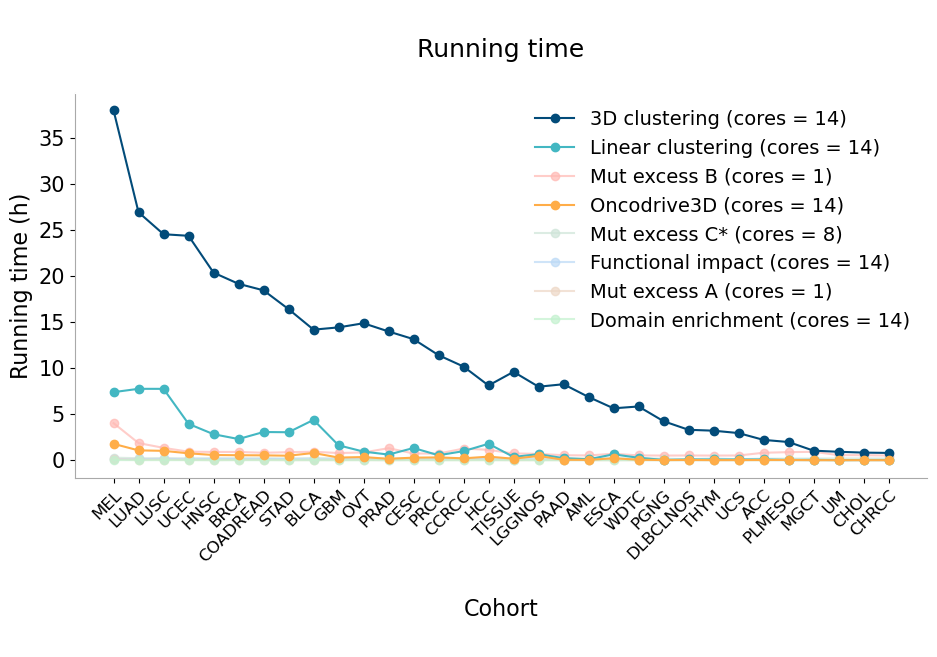

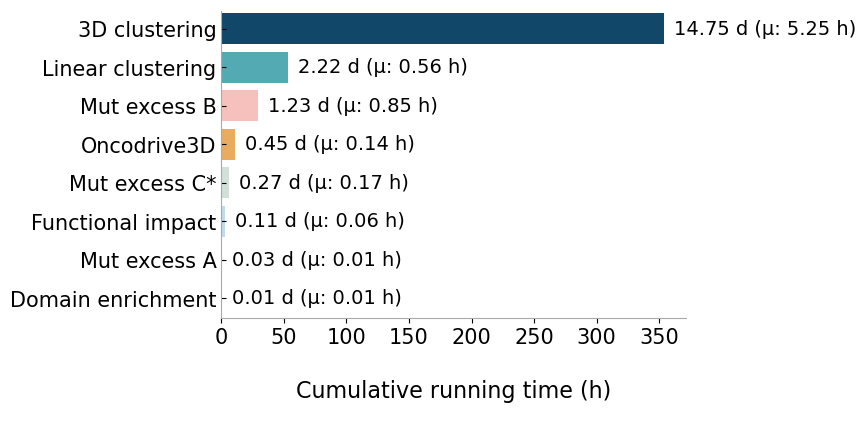

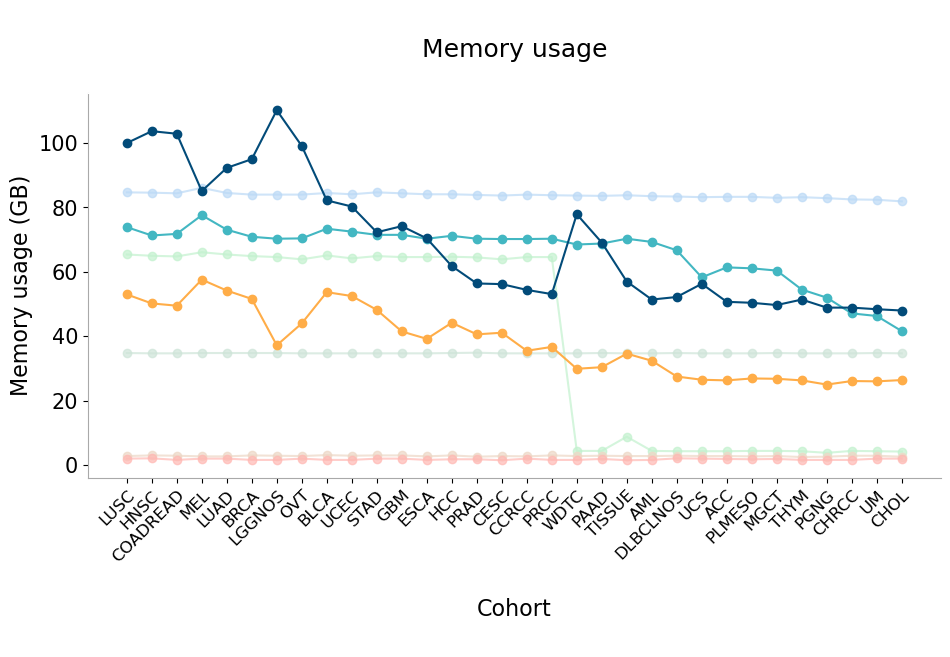

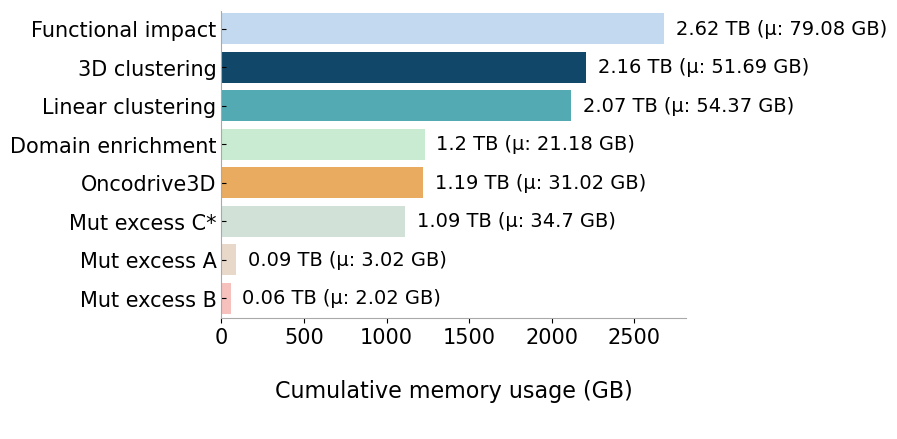

In [30]:
fig, ax = plt.subplots(figsize = (11, 5))
plot_performance(methods_tcga.sort_values("Time_H_avg", ascending=False).reset_index(drop=True), 
                 colors_dict, title = "\nRunning time\n", metric = "d", 
                 ax = ax, text_ylabel = "Running time (h)", xlabel = True, ylabel = True, 
                 legend = True, cpu_allocated=cpu_allocated,
                 style="-o", plot_xticks=True, extract_cancer=True)
plt.savefig('plots_presentation/runtime_tcga_colors.png', dpi=300, bbox_inches='tight')
plt.show

fig, ax = plt.subplots(figsize = (6, 4))
plot_sum(methods_tcga, colors_dict, title="", ax=ax, distance = 8, xlabel_text = "\nCumulative running time (h)\n", metric="d")
plt.savefig('plots_presentation/cumulative_runtime_tcga_colors.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (11, 5))
plot_performance(methods_tcga.sort_values("Memory_GB_avg", ascending=False).reset_index(drop=True), 
             colors_dict, title = "\nMemory usage\n", target = "Memory_GB", metric = "TB",
             ax = ax, text_ylabel = "Memory usage (GB)",
             xlabel = True, ylabel = True, legend = False,  cpu_allocated=cpu_allocated,
             style="-o", plot_xticks=True, extract_cancer=True)
plt.savefig('plots_presentation/memory_tcga_colors.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (6, 4))
plot_sum(methods_tcga, colors_dict, title="", ax=ax, distance = 70, 
         xlabel_text = "\nCumulative memory usage (GB)\n", target="Memory_GB", metric="TB")
plt.savefig('plots_presentation/cumulative_memory_tcga_colors.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# fig, ax = plt.subplots(figsize = (11, 5))
# plot_performance(methods.sort_values("Time_H_avg", ascending=False).reset_index(drop=True), 
#                  method2color, title = "\nRunning time\n", metric = "d", 
#                  ax = ax, text_ylabel = "Running time (h)", xlabel = True, ylabel = True, 
#                  legend = True, cpu_allocated=cpu_allocated,
#                  style="-", plot_xticks=False, extract_cancer=False)
# plt.savefig('plots/suppl/runtime_colors.png', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(figsize = (6, 4))
# plot_sum(methods, method2color, title="", ax=ax, distance = 25, xlabel_text = "\nCumulative running time (h)\n", metric="d")
# plt.savefig('plots/suppl/cumulative_runtime_colors.png', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(figsize = (11, 5))
# plot_performance(methods.sort_values("Memory_GB_avg", ascending=False).reset_index(drop=True), 
#              method2color, title = "\nMemory usage\n", target = "Memory_GB", metric = "TB",
#              ax = ax, text_ylabel = "Memory usage (GB)", smooth=True,
#              xlabel = True, ylabel = True, legend = False,  cpu_allocated=cpu_allocated,
#              style="-", plot_xticks=False, extract_cancer=False)
# plt.savefig('plots/suppl/memory_colors.png', dpi=300, bbox_inches='tight')
# plt.show()

# fig, ax = plt.subplots(figsize = (6, 4))
# plot_sum(methods, method2color, title="", ax=ax, distance = 70, 
#          xlabel_text = "\nCumulative memory usage (GB)\n", target="Memory_GB", metric="TB", rotate_xticks=True)
# plt.savefig('plots/suppl/cumulative_memory_colors.png', dpi=300, bbox_inches='tight')
# plt.show()